In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
from scipy.sparse import csr_matrix
from sklearn import tree
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import graphviz
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Perceptron
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# import train set
# attributes are the INDICES of non-zero values
train = pd.read_csv('train.txt', header=None)

In [3]:
train

,0
0,0\t96 183 367 379 387 1041 1117 1176 1327 1546...
1,0\t31 37 137 301 394 418 514 581 671 729 934 1...
2,0\t169 394 435 603 866 1418 1626 1744 1799 217...
3,0\t72 181 231 275 310 355 369 379 400 587 642 ...
4,0\t37 379 453 503 547 611 684 716 794 866 1108...
...,...
795,1\t39 120 345 400 412 558 729 1153 1176 1220 1...
796,0\t43 51 280 356 378 543 557 640 666 701 703 7...
797,0\t63 232 360 405 433 447 474 751 1069 1168 12...
798,0\t83 159 290 462 505 509 531 547 737 969 1050...


In [4]:
# import test set
test = pd.read_csv('test.txt', header=None)
test

,0
0,259 521 546 565 671 769 858 876 1056 1252 1392...
1,96 158 195 436 518 541 588 642 804 843 978 115...
2,13 169 354 587 803 1241 1472 1586 1605 1638 16...
3,10 91 184 191 546 825 978 1077 1155 1220 1297 ...
4,37 85 119 191 349 390 437 458 671 707 1454 157...
...,...
345,43 150 273 363 797 889 1014 1016 1077 1176 135...
346,34 118 132 150 162 259 347 470 477 479 613 651...
347,84 250 263 616 1220 1289 1314 1384 1440 1442 1...
348,121 136 165 207 232 309 375 412 453 460 521 72...


In [5]:
# split attributes and label
train = train[0].str.split('\t', expand=True)
train

,0,1
0,0,96 183 367 379 387 1041 1117 1176 1327 1546 18...
1,0,31 37 137 301 394 418 514 581 671 729 934 1006...
2,0,169 394 435 603 866 1418 1626 1744 1799 2179 2...
3,0,72 181 231 275 310 355 369 379 400 587 642 879...
4,0,37 379 453 503 547 611 684 716 794 866 1108 13...
...,...,...
795,1,39 120 345 400 412 558 729 1153 1176 1220 1287...
796,0,43 51 280 356 378 543 557 640 666 701 703 717 ...
797,0,63 232 360 405 433 447 474 751 1069 1168 1272 ...
798,0,83 159 290 462 505 509 531 547 737 969 1050 11...


In [6]:
train_x = pd.DataFrame(train[1])
train_x

,1
0,96 183 367 379 387 1041 1117 1176 1327 1546 18...
1,31 37 137 301 394 418 514 581 671 729 934 1006...
2,169 394 435 603 866 1418 1626 1744 1799 2179 2...
3,72 181 231 275 310 355 369 379 400 587 642 879...
4,37 379 453 503 547 611 684 716 794 866 1108 13...
...,...
795,39 120 345 400 412 558 729 1153 1176 1220 1287...
796,43 51 280 356 378 543 557 640 666 701 703 717 ...
797,63 232 360 405 433 447 474 751 1069 1168 1272 ...
798,83 159 290 462 505 509 531 547 737 969 1050 11...


In [7]:
train_y = pd.DataFrame(train[0])
train_y

,0
0,0
1,0
2,0
3,0
4,0
...,...
795,1
796,0
797,0
798,0


In [8]:
class MatrixParser:
    def __init__(self):
        pass
    
    # calculate the length needed for matrix column
    def calculateMatrixColumn(self, arr):
        colNum = 0
        for row in arr:
            for indices in row:
                # only match digits
                indices = re.findall(r'[0-9]+', indices)
                # change each index to int in np arr
                np_arr = np.array(indices, dtype=int)
            maxInd = max(np_arr)
            colNum = max(colNum, maxInd)
        print(colNum)
        return colNum
    
    # parse indices to csr matrix
    def parseIndexToMatrix(self, arr, colNum):
        res = []
        for row in arr:
            for indices in row:
                # only match digits
                indices = re.findall(r'[0-9]+', indices)
                # change each index to int in np arr
                np_arr = np.array(indices, dtype=int)
                # new arr with existing index as 1, rest is 0
                # every record has same length of arr to insert indices to
                new_arr = [0] * (colNum + 1)
                for ind in np_arr:
                    new_arr[ind] = 1
            res.append(new_arr)
            
        train_x_matrix = csr_matrix(res)
        print(train_x_matrix)
        return train_x_matrix

In [9]:
# convert train x to csr matrix
train_x_np = train_x.to_numpy()
obj = MatrixParser()
col_num = obj.calculateMatrixColumn(train_x_np)
train_x_matrix = obj.parseIndexToMatrix(train_x_np, col_num)

100000
  (0, 96)	1
  (0, 183)	1
  (0, 367)	1
  (0, 379)	1
  (0, 387)	1
  (0, 1041)	1
  (0, 1117)	1
  (0, 1176)	1
  (0, 1327)	1
  (0, 1546)	1
  (0, 1862)	1
  (0, 2068)	1
  (0, 2357)	1
  (0, 2369)	1
  (0, 2389)	1
  (0, 2904)	1
  (0, 3171)	1
  (0, 3172)	1
  (0, 3221)	1
  (0, 3269)	1
  (0, 3341)	1
  (0, 3596)	1
  (0, 3794)	1
  (0, 3832)	1
  (0, 3888)	1
  :	:
  (799, 98229)	1
  (799, 98478)	1
  (799, 98527)	1
  (799, 98532)	1
  (799, 98588)	1
  (799, 98739)	1
  (799, 98751)	1
  (799, 98752)	1
  (799, 98883)	1
  (799, 98935)	1
  (799, 98977)	1
  (799, 98996)	1
  (799, 99019)	1
  (799, 99111)	1
  (799, 99220)	1
  (799, 99298)	1
  (799, 99348)	1
  (799, 99442)	1
  (799, 99511)	1
  (799, 99601)	1
  (799, 99638)	1
  (799, 99762)	1
  (799, 99823)	1
  (799, 99911)	1
  (799, 99945)	1


In [10]:
# convert test x to csr matrix
test_x_np = test.to_numpy()
obj = MatrixParser()
test_col_num = obj.calculateMatrixColumn(test_x_np)
test_x_matrix = obj.parseIndexToMatrix(test_x_np, test_col_num)

100000
  (0, 259)	1
  (0, 521)	1
  (0, 546)	1
  (0, 565)	1
  (0, 671)	1
  (0, 769)	1
  (0, 858)	1
  (0, 876)	1
  (0, 1056)	1
  (0, 1252)	1
  (0, 1392)	1
  (0, 1480)	1
  (0, 1584)	1
  (0, 1756)	1
  (0, 1952)	1
  (0, 1985)	1
  (0, 2027)	1
  (0, 2281)	1
  (0, 2299)	1
  (0, 2438)	1
  (0, 2526)	1
  (0, 2677)	1
  (0, 2730)	1
  (0, 2787)	1
  (0, 2790)	1
  :	:
  (349, 97251)	1
  (349, 97312)	1
  (349, 97328)	1
  (349, 97414)	1
  (349, 97439)	1
  (349, 97578)	1
  (349, 97793)	1
  (349, 97847)	1
  (349, 97995)	1
  (349, 98180)	1
  (349, 98298)	1
  (349, 98308)	1
  (349, 98336)	1
  (349, 98440)	1
  (349, 98507)	1
  (349, 98994)	1
  (349, 99067)	1
  (349, 99076)	1
  (349, 99166)	1
  (349, 99257)	1
  (349, 99424)	1
  (349, 99560)	1
  (349, 99611)	1
  (349, 99680)	1
  (349, 99801)	1


In [11]:
# convert train y to numpy array
train_y = train_y.to_numpy().flatten()
train_y = train_y.astype(int)
train_y

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,

#### Apply mutual info classification SelectKBest
#### Different random states for experiments for reproducibility

In [12]:
# apply mutual information feature selection to eliminate dependent features
print("current train_x shape: ", train_x_matrix.shape)

def mutual_info(train_x_matrix, train_y):
    return mutual_info_classif(train_x_matrix, train_y, random_state=72)

mutual_info_kbest = SelectKBest(score_func=mutual_info, k=300)
train_x_matrix = mutual_info_kbest.fit_transform(train_x_matrix, train_y)
print("train_x shape after mutual info selection: ", train_x_matrix.shape)

print("current test_x shape: ", test_x_matrix.shape)
test_x_matrix = mutual_info_kbest.transform(test_x_matrix)
print("test_x shape after mutual info selection: ", test_x_matrix.shape)

current train_x shape:  (800, 100001)
train_x shape after mutual info selection:  (800, 300)
current test_x shape:  (350, 100001)
test_x shape after mutual info selection:  (350, 300)


#### Apply chi2 test SelectKBest
#### Different random states for experiments for reproducibility

In [13]:
# # apply chi2 feature selection to eliminate irrelevant features
# print("current train_x shape: ", train_x_matrix.shape)
# chi2_kbest = SelectKBest(chi2, k=350)
# train_x_matrix = chi2_kbest.fit_transform(train_x_matrix, train_y)
# print("train_x shape after chi2 selection: ", train_x_matrix.shape)

# print("current test_x shape: ", test_x_matrix.shape)
# test_x_matrix = chi2_kbest.transform(test_x_matrix)
# print("test_x shape after chi2 selection: ", test_x_matrix.shape)

#### Apply resampling to over sample the under represented label in train set
#### Different random states for experiments for reproducibility

In [14]:
# shuffle the train x and y to prevent overfitting
train_x_matrix, train_y = shuffle(train_x_matrix, train_y, random_state=72)

# produce a validation set to validate the model
train_x_matrix, validation_x, train_y, validation_y = train_test_split(
    train_x_matrix, train_y, test_size=0.15, random_state=72)

<Axes: ylabel='Count'>

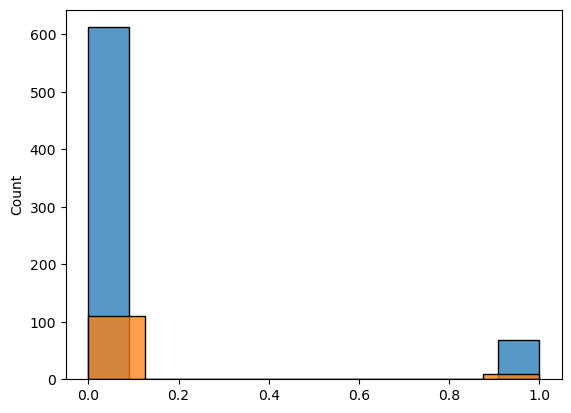

In [15]:
# check the distribution of the labels
train_label_dist = sns.histplot(data=train_y)
train_label_dist
validation_label_dist = sns.histplot(data=validation_y)
validation_label_dist
# the labels are imbalanced

In [16]:
# # highly imbalanced dataset, so apply resampling to over 
# # sample the under represented label in train set and validation set
# ros = RandomOverSampler(random_state=63)
# train_x_resampled, train_y_resampled = ros.fit_resample(train_x_matrix, train_y)

In [17]:
sm = SMOTE(random_state=72)
train_x_resampled, train_y_resampled = sm.fit_resample(train_x_matrix, train_y)

train/val/test ratio:  0.7225501770956316 0.07083825265643448 0.2066115702479339
Train label is 1:  612 Train label is 0:  612
Validation label is 1:  10 validation label is 0:  110


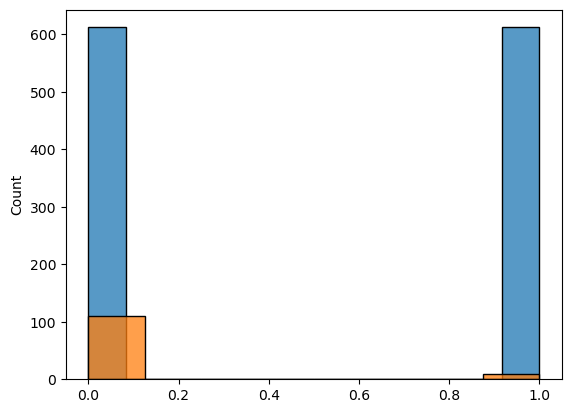

In [18]:
# check resampled dataset
sns.histplot(data=train_y_resampled)
sns.histplot(data=validation_y)

# get the amount for resampled train x validation x and test x
train_x_resampled_length = train_x_resampled.shape[0]
test_x_length = test_x_matrix.shape[0]
val_x_length = validation_x.shape[0]

# check the ratio of train val test sets after resampling
train_ratio = train_x_resampled_length / (train_x_resampled_length + test_x_length + val_x_length)
test_ratio = test_x_length / (train_x_resampled_length + test_x_length + val_x_length)
val_ratio = val_x_length / (train_x_resampled_length + test_x_length + val_x_length)

# the result shows it is roughly 70/10/20 which is common
print("train/val/test ratio: ", train_ratio, val_ratio, test_ratio)

# check the ratio of 0 and 1 in train set
# this is important because stratified cross validation fold will
# follow this ratio too
res_1 = 0
res_0 = 0
for res in train_y_resampled:
    if res == 1:
        res_1 += 1
    elif res == 0:
        res_0 += 1
# the result shows after resampling there is equal amount of 
# label 1 and label 0 in train y
print("Train label is 1: ", res_1, "Train label is 0: ", res_0)

res_1_val = 0
res_0_val = 0
for res in validation_y:
    if res == 1:
        res_1_val += 1
    elif res == 0:
        res_0_val += 1
# the result shows after resampling there is equal amount of 
# label 1 and label 0 in val y
print("Validation label is 1: ", res_1_val, "validation label is 0: ", res_0_val)

#### Experiments for Decision Tree Classifer with Stratified Cross Validation
#### Different random states for experiments for reproducibility, the random_state each experiment used matches random_state in RandomOverSampler above. Details can be found in the corresponding pdf file.

In [19]:
# # shuffle the resampled data before dividing into kfolds
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=70)

# # split to n folds with the same class label ratio as dataset
# for train_index, test_index in skf.split(train_x_resampled, train_y_resampled):
#     # extract train folds x y 
#     train_x = train_x_resampled[train_index]
#     train_y = train_y_resampled[train_index]
#     # extract test fold x and y
#     test_x = train_x_resampled[test_index]
#     test_y = train_y_resampled[test_index]
    
#     # apply decision tree
#     # applying different max depth and see what works better
#     clf = tree.DecisionTreeClassifier(random_state=70)
    
#     # fit model on train folds
#     clf = clf.fit(train_x, train_y)
#     print("tree depth: ", clf.get_depth())
#     # predict on test fold
#     test_y_pred = clf.predict(test_x)
    
#     train_y_1 = 0
#     train_y_0 = 0
#     for label in train_y:
#         if label == 1:
#             train_y_1 += 1
#         elif label == 0:
#             train_y_0 += 1
    
#     test_y_1 = 0
#     test_y_0 = 0
#     for label in test_y:
#         if label == 1:
#             test_y_1 += 1
#         elif label == 0:
#             test_y_0 += 1
    
#     # train folds and test fold label ratio follows the ratio in the dataset which is good
#     print("train label ratio: ", train_y_1 / (train_y_0 + train_y_1), train_y_0 / (train_y_0 + train_y_1))
#     print("test label ratio: ", test_y_1 / (test_y_0 + test_y_1), test_y_0 / (test_y_0 + test_y_1))
    
#     f1_scores = []
#     print("f1 score: ", f1_score(test_y, test_y_pred))
#     print("confusion matrix: \n", confusion_matrix(test_y, test_y_pred))
#     f1_scores.append(f1_score(test_y, test_y_pred))

# print("average f1 score: ", sum(f1_scores) / len(f1_scores))

# # make prediction on validation set
# label_pred = clf.predict(validation_x)
# labels_pred = []
# for label in label_pred:
#     labels_pred.append(label)
# print(labels_pred)
# print(validation_y)
# print("f1 score validation set: ", f1_score(validation_y, labels_pred))
    
# visualize the tree
# decision_tree_visual = tree.export_graphviz(clf, out_file=None, filled=True) 
# graph = graphviz.Source(decision_tree_visual) 
# graph.render("decision_tree_visualization")

In [20]:
# # predict on test set with dt clf
# label_pred = clf.predict(test_x_matrix)
# for label in label_pred:
#     print(label)

#### The Naive Bayes algorithm that is being used here is Bernoulli Naive Bayes. The reason being in the dataset 0 and 1 are binary values that represent the absence and presence of a feature, which is suitable for Bernoulli Naive Bayes.


#### Experiments for Bernoulli Naive Bayes Classifer with Stratified Cross Validation
#### Different random states for experiments for reproducibility, the random_state each experiment used matches random_state in RandomOverSampler above. Details can be found in the corresponding pdf file.


In [21]:
# shuffle the resampled data before dividing into kfolds
skf_nb = StratifiedKFold(n_splits=5, shuffle=True, random_state=72)

# split to n folds with the same class label ratio as dataset
for train_index, test_index in skf_nb.split(train_x_resampled, train_y_resampled):
    # extract train folds x y 
    train_x = train_x_resampled[train_index]
    train_y = train_y_resampled[train_index]
    # extract test fold x and y
    test_x = train_x_resampled[test_index]
    test_y = train_y_resampled[test_index]
    
    # apply bernoulli naive bayes
    clf_nb = BernoulliNB(force_alpha=True)
    # fit model on train folds
    clf_nb = clf_nb.fit(train_x, train_y)
    # predict on test fold
    test_y_pred = clf_nb.predict(test_x)
    
    train_y_1 = 0
    train_y_0 = 0
    for label in train_y:
        if label == 1:
            train_y_1 += 1
        elif label == 0:
            train_y_0 += 1
    
    test_y_1 = 0
    test_y_0 = 0
    for label in test_y:
        if label == 1:
            test_y_1 += 1
        elif label == 0:
            test_y_0 += 1
    
    # train folds and test fold label ratio follows the ratio in the dataset which is good
    print("train label ratio: ", train_y_1 / (train_y_0 + train_y_1), train_y_0 / (train_y_0 + train_y_1))
    print("test label ratio: ", test_y_1 / (test_y_0 + test_y_1), test_y_0 / (test_y_0 + test_y_1))
    
    f1_scores = []
    print("f1 score: ", f1_score(test_y, test_y_pred))
    print("confusion matrix: \n", confusion_matrix(test_y, test_y_pred))
    f1_scores.append(f1_score(test_y, test_y_pred))

print("average f1 score: ", sum(f1_scores) / len(f1_scores))

# make prediction on validation set
label_pred = clf_nb.predict(validation_x)
labels_pred = []
for label in label_pred:
    labels_pred.append(label)
print(labels_pred)
print(validation_y)
print("f1 score validation set: ", f1_score(validation_y, labels_pred))

train label ratio:  0.5005107252298263 0.49948927477017363
test label ratio:  0.49795918367346936 0.5020408163265306
f1 score:  0.6839378238341969
confusion matrix: 
 [[118   5]
 [ 56  66]]
train label ratio:  0.5005107252298263 0.49948927477017363
test label ratio:  0.49795918367346936 0.5020408163265306
f1 score:  0.6145251396648045
confusion matrix: 
 [[121   2]
 [ 67  55]]
train label ratio:  0.49948927477017363 0.5005107252298263
test label ratio:  0.5020408163265306 0.49795918367346936
f1 score:  0.6120218579234973
confusion matrix: 
 [[118   4]
 [ 67  56]]
train label ratio:  0.49948927477017363 0.5005107252298263
test label ratio:  0.5020408163265306 0.49795918367346936
f1 score:  0.7142857142857142
confusion matrix: 
 [[119   3]
 [ 53  70]]
train label ratio:  0.5 0.5
test label ratio:  0.5 0.5
f1 score:  0.6666666666666666
confusion matrix: 
 [[116   6]
 [ 58  64]]
average f1 score:  0.6666666666666666
[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [22]:
# predict test set with nb clf
label_pred = clf_nb.predict(test_x_matrix)
for label in label_pred:
    print(label)

1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0


#### Experiments for Perceptron Classifer with Stratified Cross Validation
#### Different random states for experiments for reproducibility, the random_state each experiment used matches random_state in RandomOverSampler above. Details can be found in the corresponding pdf file.

In [23]:
# # shuffle the resampled data before dividing into kfolds
# skf_per = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)

# # split to n folds with the same class label ratio as dataset
# for train_index, test_index in skf_per.split(train_x_resampled, train_y_resampled):
#     # extract train folds x y 
#     train_x = train_x_resampled[train_index]
#     train_y = train_y_resampled[train_index]
#     # extract test fold x and y
#     test_x = train_x_resampled[test_index]
#     test_y = train_y_resampled[test_index]
    
#     # apply MLP classifier
#     clf_per = Perceptron(random_state=71)
#     # fit model on train fold
#     clf_per = clf_per.fit(train_x, train_y)
#     # predict on test fold
#     test_y_pred = clf_per.predict(test_x)
    
#     train_y_1 = 0
#     train_y_0 = 0
#     for label in train_y:
#         if label == 1:
#             train_y_1 += 1
#         elif label == 0:
#             train_y_0 += 1
    
#     test_y_1 = 0
#     test_y_0 = 0
#     for label in test_y:
#         if label == 1:
#             test_y_1 += 1
#         elif label == 0:
#             test_y_0 += 1
    
#     # train folds and test fold label ratio follows the ratio in the dataset which is good
#     print("train label ratio: ", train_y_1 / (train_y_0 + train_y_1), train_y_0 / (train_y_0 + train_y_1))
#     print("test label ratio: ", test_y_1 / (test_y_0 + test_y_1), test_y_0 / (test_y_0 + test_y_1))
    
#     f1_scores = []
#     print("f1 score: ", f1_score(test_y, test_y_pred))
#     print("confusion matrix: \n", confusion_matrix(test_y, test_y_pred))
#     f1_scores.append(f1_score(test_y, test_y_pred))

# print("average f1 score: ", sum(f1_scores) / len(f1_scores))

# # make prediction on validation set
# label_pred = clf_per.predict(validation_x)
# labels_pred = []
# for label in label_pred:
#     labels_pred.append(label)
# print(labels_pred)
# print(validation_y)
# print("f1 score validation set: ", f1_score(validation_y, labels_pred))

In [24]:
# predict test set with per clf
label_pred = clf_per.predict(test_x_matrix)
for label in label_pred:
    print(label)

NameError: name 'clf_per' is not defined